In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
source('0_parameters.sh')


In [3]:
source(snpnet_misc_R)

In [8]:
UKB_phe <- 'covid19_severe'
HGI_case_control <- 'B2'
HGI_suffix <- 'eur_leave_ukbb_23andme'
clump_p1 <- '1e-5'


In [58]:
covariates <- c('age', 'sex', paste0('PC', 1:10))


In [6]:
# read phe file
file.path(data_d, 'UKB_PRS_eval', 'UKB.WB.phe.gz') %>%
fread(colClasses = c('#FID'='character', 'IID'='character')) %>%
rename('FID'='#FID') -> phe_df


In [9]:
# read PRS file
PRS_col <- paste('PRS', HGI_case_control, HGI_suffix, clump_p1, sep='.')
file.path(data_d, 'UKB_PRS_clump.phe.gz') %>%
fread(
    colClasses = c('#FID'='character', 'IID'='character'),
    select=c('#FID', 'IID', PRS_col)
) %>%
rename('FID'='#FID') %>%
rename(!!'geno_score' := all_of(PRS_col)) -> PRS_df



In [13]:
# join them and restrict to the WB
phe_df %>% left_join(PRS_df, by = c("FID", "IID")) %>%
mutate(split = 'UKB_WB') -> df


In [15]:
df %>% 
rename(!!'phe' := all_of(UKB_phe)) %>%
rename(!!'covar_score' := all_of(paste(UKB_phe, 'covar_score', sep='.'))) -> dff


In [31]:
generate_eval_from_df_with_renamed_cols <- function(dff){
    dff %>% count(split, phe) %>%
    mutate(phe = if_else(phe==2, 'case_n', 'control_n')) %>%
    spread(phe, n) %>% filter(control_n>0, case_n>0) %>%
    arrange(-case_n) -> split_cnt_df

    dff %>%
    build_eval_df((split_cnt_df %>% pull(split)), 'auc') %>%
    left_join(split_cnt_df, by='split') %>%
    mutate(
        UKB_phe = UKB_phe,
        HGI_case_control = HGI_case_control,
        HGI_suffix = HGI_suffix,
        clump_p1 = clump_p1
    ) %>%
    select(UKB_phe, HGI_case_control, HGI_suffix, clump_p1, geno, covar, geno_covar, case_n, control_n)    
}


In [33]:
dff %>% generate_eval_from_df_with_renamed_cols()

UKB_phe,HGI_case_control,HGI_suffix,clump_p1,geno,covar,geno_covar,case_n,control_n
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>
covid19_severe,B2,eur_leave_ukbb_23andme,1e-5,0.5361687,0.6148025,0.5903785,633,336496


In [34]:
# prepare data frames for the plots
dff %>% drop_na(geno_score, phe) %>%
mutate(geno_score_percentile = rank(-geno_score) / n()) -> plot_df

summary_plot_df <- plot_df %>%
compute_summary_df('geno_score_percentile', 'phe', family='binomial')

In [50]:
p1 <- plot_df %>% plot_PRS_binomial() +
labs(
    y = 'LD-clumping based PRS (Z-score)',
    title = sprintf('%s  %s', UKB_phe, PRS_col)
)


In [52]:
p2 <- summary_plot_df %>% plot_PRS_bin_vs_OR() +
labs(
    x = 'Percentitle of LD-clumping based PRS',
    title = sprintf('%s  %s', UKB_phe, PRS_col)
)


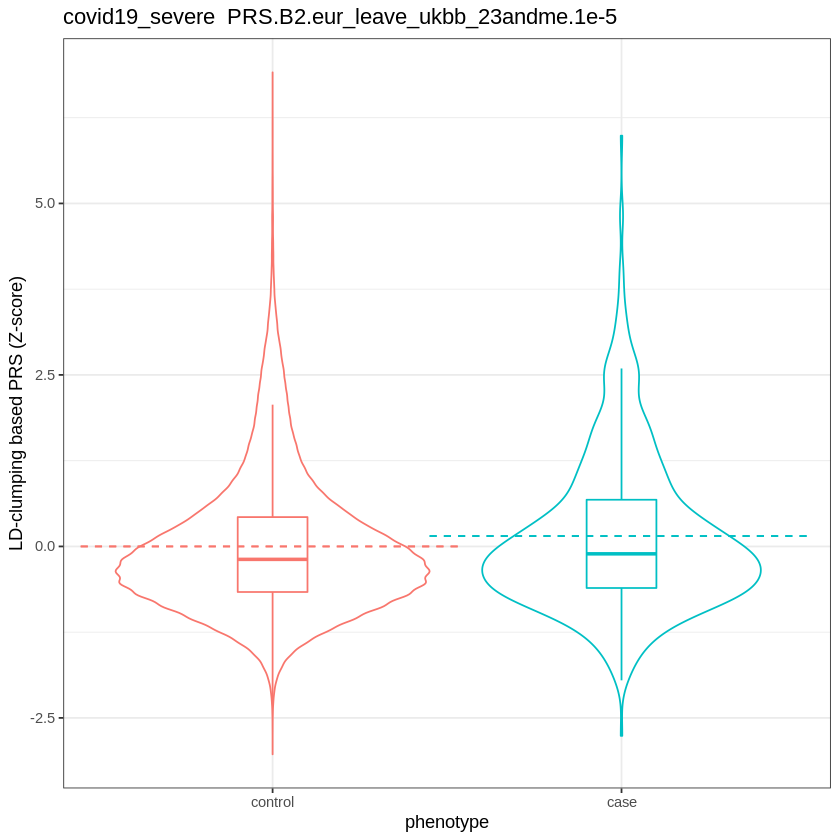

In [51]:
p1

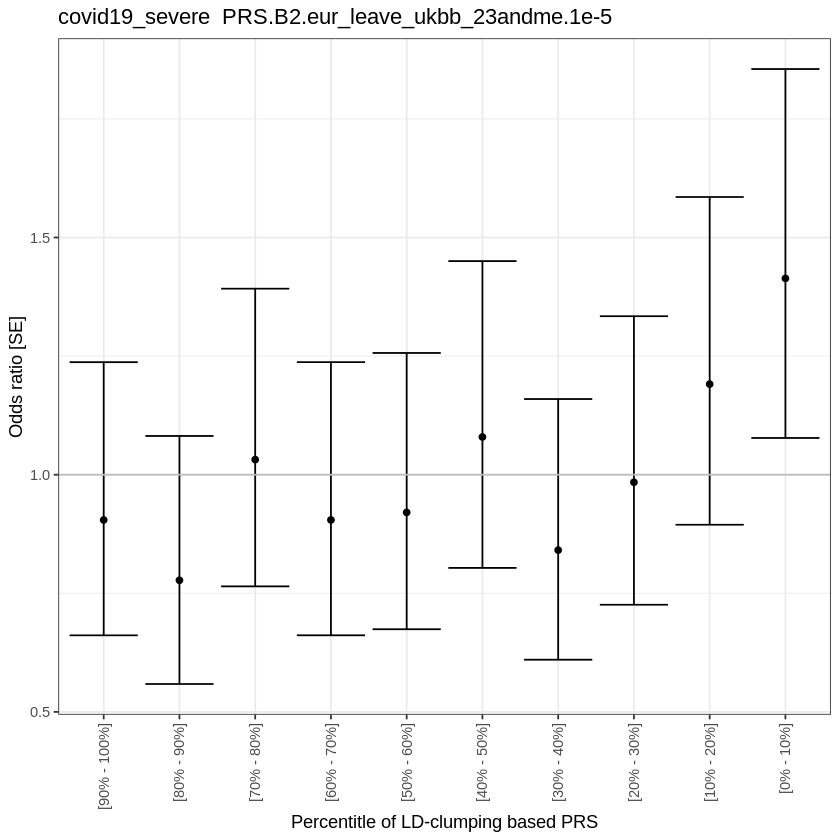

In [53]:
p2